# Анализ изменения поведения клиентов
Данный скрипт предназначен для анализа и визуализации данных маркетинговой компании

Автор: Ерошкин Юрий, июнь 2025.

In [1]:
# Импорт библиотек для анализа и визуализации
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
sns.set_style('whitegrid')  # Сетчатый стиль для всех графиков
sns.set_palette("Set2")     # Фиксируем палитру для всех графиков

from tqdm import tqdm

# Для корректного отображения графиков в jupyter
%matplotlib inline

In [2]:
#Загружаем данные из CSV и Parquet файлов
df_persons = pd.read_csv('Person.csv', sep=',')
df_goods = pd.read_csv('Goods.csv', sep=',')
df_actions = pd.read_csv('Actions.csv', sep=',')
df_purchases = pd.read_parquet('List_Purchases.parquet')
df_cheques = pd.read_parquet('List_Cheques.parquet')

## Смотрим на структуру данных и делаем предобработку

In [3]:
def get_df_info(df):
    print(df.shape)
    display(df.head())
    na = df.isnull().sum()
    na = na[na > 0]
    if len(na) == 0:
        print("Нет пропусков")
    else:
        print("Есть пропуски:")
        display(na.sort_values(ascending=False))

### Личные данные покупателей ('Person.csv')

In [4]:
get_df_info(df_persons)  

(500000, 4)


,Person_BKEY,First_Purch_date,Age,Gend
0,162,2018-07-06 19:36:04,52,F
1,359,2017-07-14 16:27:35,60,M
2,600,2017-10-10 12:22:44,82,M
3,1042,2017-11-26 11:21:29,40,U
4,1080,2018-02-21 19:08:56,21,U


Нет пропусков


In [5]:
df_persons.describe(include='all')

,Person_BKEY,First_Purch_date,Age,Gend
count,500000.000000,500000,500000.000000,500000
unique,NaN,494603,NaN,3
top,NaN,2017-11-22 12:40:50,NaN,U
freq,NaN,3,NaN,232002
mean,249999.500000,NaN,46.470168,NaN
std,144337.711634,NaN,44.362736,NaN
min,0.000000,NaN,-7491.000000,NaN
25%,124999.750000,NaN,34.000000,NaN
50%,249999.500000,NaN,45.000000,NaN
75%,374999.250000,NaN,59.000000,NaN


Видим явные аномалии в возрасте. Удалим строки, где возраст меньше 10 и больше 100.

In [6]:
df_persons = df_persons[(df_persons['Age'] >= 10) & (df_persons['Age'] <= 100)]

Построим распределения клиентов по полу и возрасту.

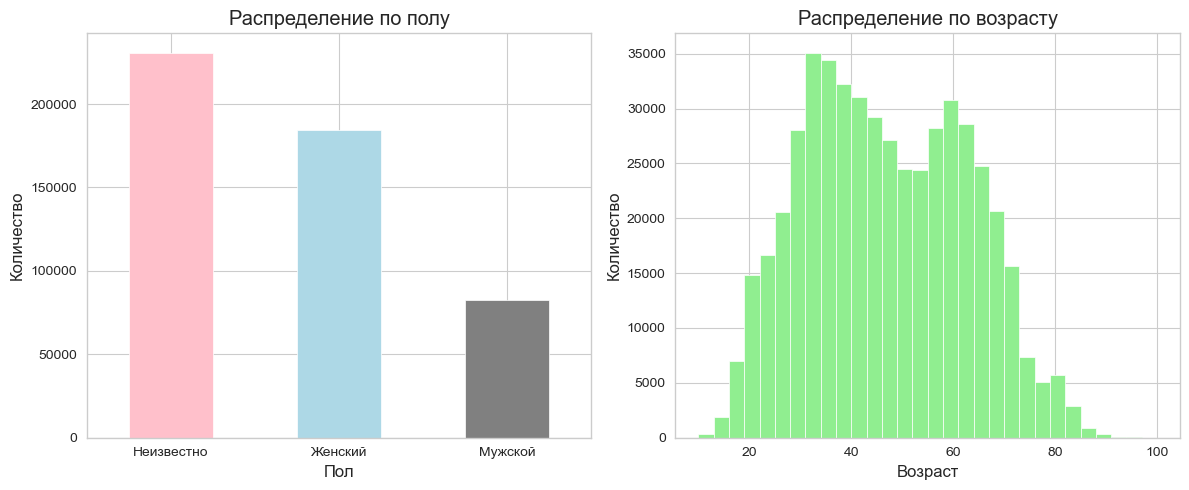

In [7]:
# Создаём фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Распределение по полу (bar chart)
gender_counts = df_persons['Gend'].value_counts()
gender_counts.index = gender_counts.index.map({'F': 'Женский', 'M': 'Мужской', 'U': 'Неизвестно'})
gender_counts.plot(kind='bar', ax=axes[0], color=['pink', 'lightblue', 'gray'])
axes[0].set_xlabel('Пол')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение по полу')
axes[0].set_xticklabels(gender_counts.index, rotation=0)

# 2. Распределение по возрасту (гистограмма)
df_persons['Age'].plot(kind='hist', bins=30, ax=axes[1], color='lightgreen')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Количество')
axes[1].set_title('Распределение по возрасту')

plt.tight_layout()
plt.show()

- Для большей части пользователей пол неизвестен, а для известных нам женский преобладает над мужским. Возможно, женщины у нас закупаются чаще, возможно мужчины реже указывают свой пол или реже заполняют нашу анкету.
- Распределение по возрасту имеет специфический вид, намекающий на потенциальную бимодальность, но в целом без аномалий.

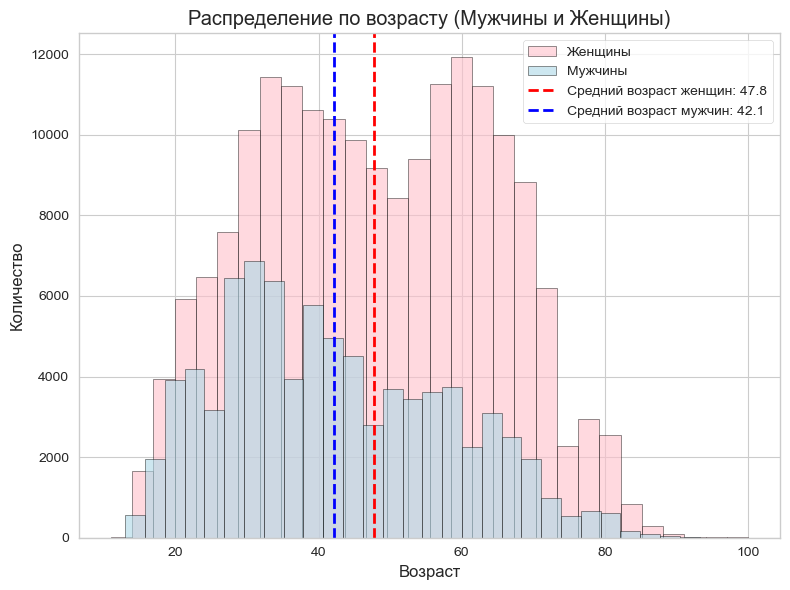

In [8]:
# Выделяем выборки по полу
men_ages = df_persons.loc[df_persons['Gend'] == 'M', 'Age']
women_ages = df_persons.loc[df_persons['Gend'] == 'F', 'Age']

# Строим гистограммы
plt.figure(figsize=(8, 6))
plt.hist(women_ages, bins=30, alpha=0.6, label='Женщины', color='pink', edgecolor='k')
plt.hist(men_ages, bins=30, alpha=0.6, label='Мужчины', color='lightblue', edgecolor='k')

# Средние значения
plt.axvline(women_ages.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Средний возраст женщин: {women_ages.mean():.1f}')
plt.axvline(men_ages.mean(), color='blue', linestyle='dashed', linewidth=2, label=f'Средний возраст мужчин: {men_ages.mean():.1f}')

plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение по возрасту (Мужчины и Женщины)')
plt.legend()
plt.tight_layout()
plt.show()


Видим, что распределения наших пользователей по возрасту сильно отличаются в зависимости от пола. Сильные подозрения на бимодальность распределения по возрасту для женщин.

Оставим от времени первой покупки только дату и построим график

In [9]:
df_persons['First_Purch_date'] = pd.to_datetime(df_persons['First_Purch_date']).dt.date
df_persons.head()

,Person_BKEY,First_Purch_date,Age,Gend
0,162,2018-07-06,52,F
1,359,2017-07-14,60,M
2,600,2017-10-10,82,M
3,1042,2017-11-26,40,U
4,1080,2018-02-21,21,U


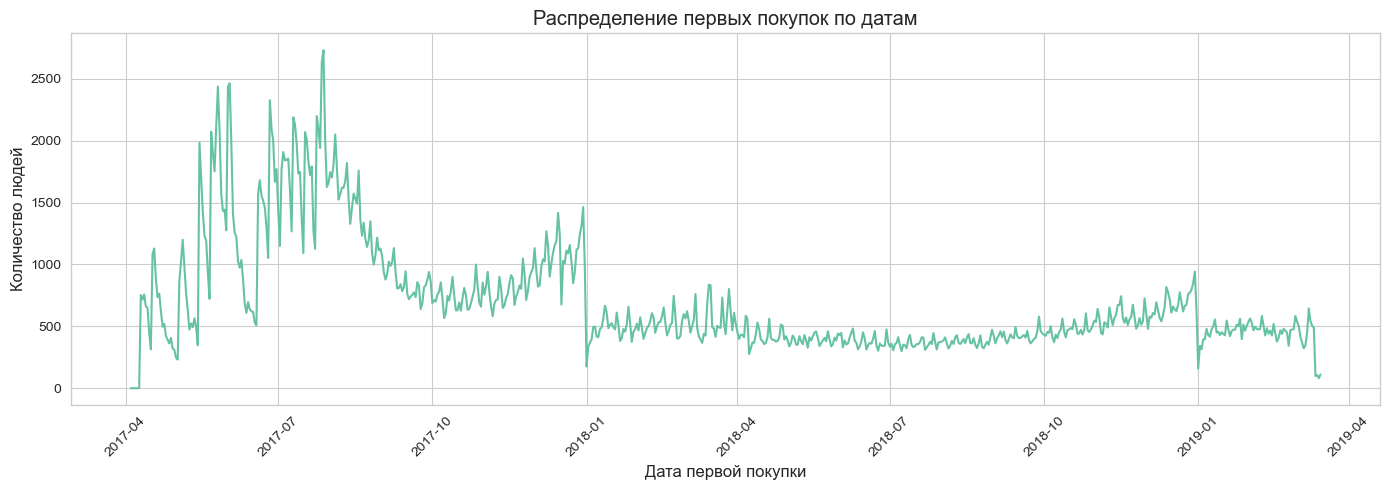

In [10]:
# Считаем количество покупок на каждую дату
date_counts = df_persons['First_Purch_date'].value_counts().sort_index()

# Строим график
plt.figure(figsize=(14, 5))
plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Дата первой покупки')
plt.ylabel('Количество людей')
plt.title('Распределение первых покупок по датам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Наблюдаем явные провалы на рубеже годов (2017->2018 и 2018->2019), то есть под Новый год у нас не появляются новые покупатели.
- Приток покупателей имел всплеск в 2017 году и затем уменьшился с течением времени, нужно сверяться, например, с датами рекламных компаний.

### Действия покупателей ('actions.csv')

In [11]:
get_df_info(df_actions)

(500000, 6)


,Person_BKEY,In_Action,Action_date,Sum_Purch_in_Action,Qnt_Purch_in_Action,Sum_from_Card
0,162,0,2019-03-21,195.00,1,0.0
1,359,1,2019-03-21,1298.93,3,300.0
2,600,1,2019-03-21,1224.17,1,-0.0
3,1042,1,2019-03-21,313.18,2,300.0
4,1080,1,2019-03-21,0.00,0,-0.0


Нет пропусков


In [12]:
df_actions.describe(include='all')

,Person_BKEY,In_Action,Action_date,Sum_Purch_in_Action,Qnt_Purch_in_Action,Sum_from_Card
count,500000.000000,500000.000000,500000,500000.000000,500000.000000,500000.000000
unique,NaN,NaN,1,NaN,NaN,NaN
top,NaN,NaN,2019-03-21,NaN,NaN,NaN
freq,NaN,NaN,500000,NaN,NaN,NaN
mean,249999.500000,0.499964,NaN,568.793305,1.390548,30.904100
std,144337.711634,0.500000,NaN,913.062545,1.727286,90.899217
min,0.000000,0.000000,NaN,0.000000,0.000000,-0.000000
25%,124999.750000,0.000000,NaN,0.000000,0.000000,0.000000
50%,249999.500000,0.000000,NaN,248.010000,1.000000,0.000000
75%,374999.250000,1.000000,NaN,792.000000,2.000000,0.000000


Заменим суммы '-0.0' на '0.0'

In [13]:
df_actions['Sum_from_Card'] = df_actions['Sum_from_Card'].replace(-0.0, 0.0)

Но на самом деле весь смысл столбца 'Sum_from_Card' не очень понятен. Возможно, это какие-то бонусные баллы, которые тратили участники. Для пояснения нужно связаться с владельцем данных. Пока убираем.

In [14]:
# Удалим столбец из датафрейма:
df_actions = df_actions.drop('Sum_from_Card', axis=1)

Дата акции одна на всех, скорее всего акция проходила один день. Нет смысла держать этот столбец, но дату акции сохраним на будущее. Никакого заметного всплеска в эту дату на графике новых клиентов нет, акция вероятно была расчитана на уже имеющихся клиентов.

In [15]:
# Сохраним action_date в переменную:
action_date = df_actions['Action_date'].iloc[0] # все значения одинаковые, берём первое

# Удалим столбец из датафрейма:
df_actions = df_actions.drop('Action_date', axis=1)

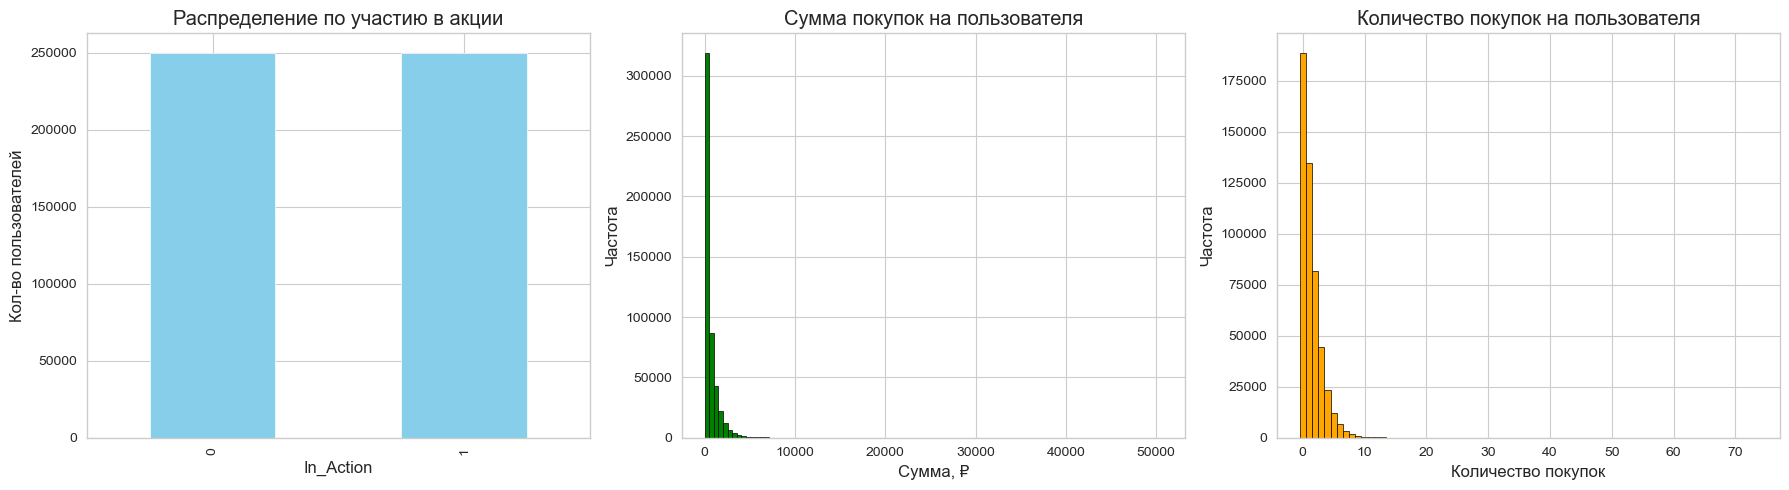

In [16]:
plt.figure(figsize=(18, 5))

# 1. In_Action - сколько людей участвовало/нет
plt.subplot(1, 3, 1)
df_actions['In_Action'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение по участию в акции')
plt.xlabel('In_Action')
plt.ylabel('Кол-во пользователей')

# 2. Sum_Purch_in_Action - сколько денег обычно тратят 
plt.subplot(1, 3, 2)
plt.hist(df_actions["Sum_Purch_in_Action"], bins=100, color='green', edgecolor='black')
plt.title('Сумма покупок на пользователя')
plt.xlabel('Сумма, ₽')
plt.ylabel('Частота')
#plt.yscale('log') # если есть длинный хвост, можно сделать ось Y логарифмической 

# 3. Qnt_Purch_in_Action
plt.subplot(1, 3, 3)
plt.hist(df_actions["Qnt_Purch_in_Action"], bins=range(0, df_actions["Qnt_Purch_in_Action"].max() + 2), color='orange', edgecolor='black', align='left')
plt.title('Количество покупок на пользователя')
plt.xlabel('Количество покупок')
plt.ylabel('Частота')
#plt.yscale('log') # если есть длинный хвост, можно сделать ось Y логарифмической 

plt.tight_layout()
plt.show()

- Видим близкое к идеальному разбиение на равные половины пользователей по участию в акции.
- На графиках сумм покупки и количества покупок на пользователя наблюдаем стандартную картину для логнормальных распределений - выбросы. Нужно от них как-то избавиться. 

Подрежем правые хвосты у распределений по 99-процентилю.

In [17]:
# Находим пороговые значения по 99-процентилю
sum_purch_cut = df_actions["Sum_Purch_in_Action"].quantile(0.99)
qnt_purch_cut = df_actions["Qnt_Purch_in_Action"].quantile(0.99)

# Оставляем только те строки, где оба значения НЕ превышают порог
df_actions = df_actions[
    (df_actions["Sum_Purch_in_Action"] <= sum_purch_cut) &
    (df_actions["Qnt_Purch_in_Action"] <= qnt_purch_cut)
]

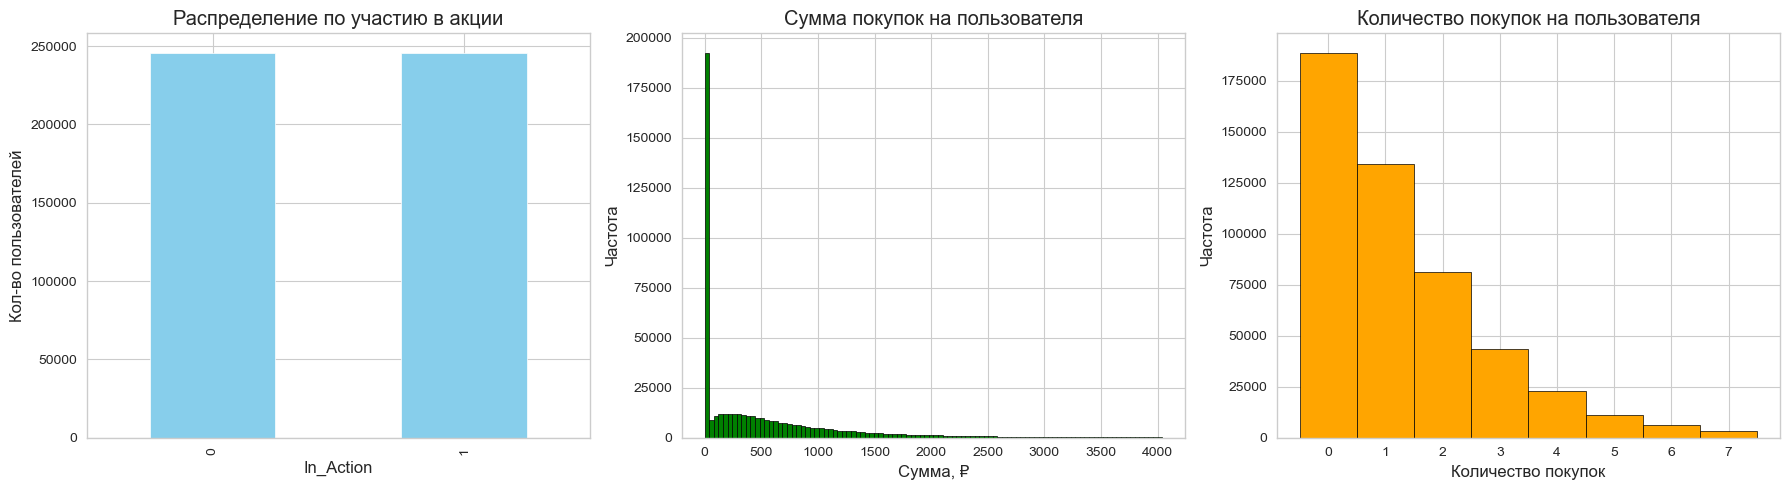

In [18]:
plt.figure(figsize=(18, 5))

# 1. In_Action - сколько людей участвовало/нет
plt.subplot(1, 3, 1)
df_actions['In_Action'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение по участию в акции')
plt.xlabel('In_Action')
plt.ylabel('Кол-во пользователей')

# 2. Sum_Purch_in_Action - сколько денег обычно тратят 
plt.subplot(1, 3, 2)
plt.hist(df_actions["Sum_Purch_in_Action"], bins=100, color='green', edgecolor='black')
plt.title('Сумма покупок на пользователя')
plt.xlabel('Сумма, ₽')
plt.ylabel('Частота')
#plt.yscale('log') # если есть длинный хвост, можно сделать ось Y логарифмической 

# 3. Qnt_Purch_in_Action
plt.subplot(1, 3, 3)
plt.hist(df_actions["Qnt_Purch_in_Action"], bins=range(0, df_actions["Qnt_Purch_in_Action"].max() + 2), color='orange', edgecolor='black', align='left')
plt.title('Количество покупок на пользователя')
plt.xlabel('Количество покупок')
plt.ylabel('Частота')
#plt.yscale('log') # если есть длинный хвост, можно сделать ось Y логарифмической 

plt.tight_layout()
plt.show()

Заметим, что большое количество пользователей купили 0 товаров на сумму в 0 рублей - не удаляем эти строки, это может быть важной информацией Но построим для интереса распределение тех, кто хоть что-то купил.

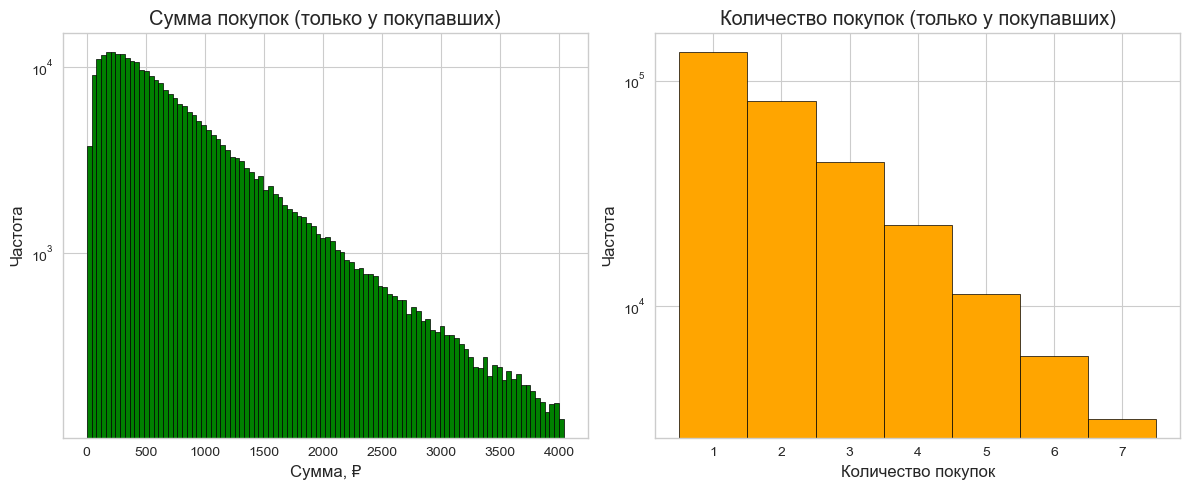

In [19]:
# Фильтруем только пользователей, у кого суммы и количество покупок больше нуля
df_bought = df_actions[(df_actions["Sum_Purch_in_Action"] > 0) & (df_actions["Qnt_Purch_in_Action"] > 0)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_bought["Sum_Purch_in_Action"], bins=100, color='green', edgecolor='black')
plt.title('Сумма покупок (только у покупавших)')
plt.xlabel('Сумма, ₽')
plt.ylabel('Частота')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(df_bought["Qnt_Purch_in_Action"], 
         bins=range(1, df_bought["Qnt_Purch_in_Action"].max() + 2),
         color='orange', edgecolor='black', align='left')
plt.title('Количество покупок (только у покупавших)')
plt.xlabel('Количество покупок')
plt.ylabel('Частота')
plt.yscale('log')

plt.tight_layout()
plt.show()

Посмотрим, как пользователи, которые ничего у нас не купили, распределены в зависимости от того, участвовали они в акции или нет.

In_Action
0    99128
1    89725
Name: count, dtype: int64


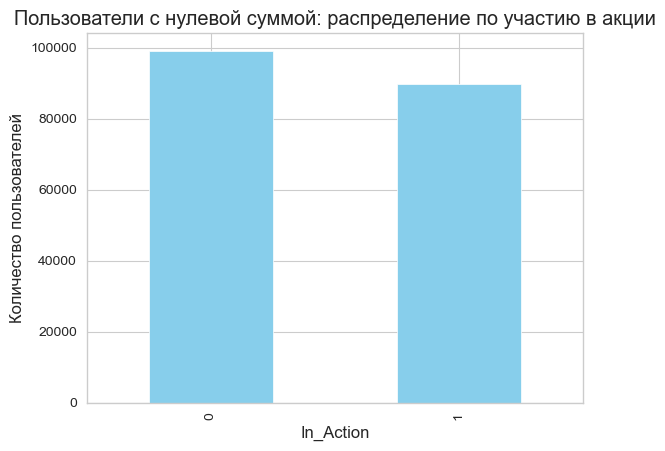

In [20]:
# Фильтруем только тех, у кого сумма покупок == 0
df_zero = df_actions[df_actions["Sum_Purch_in_Action"] == 0]

# Считаем, сколько таких среди участвовавших и не участвовавших в акции
cnt_by_action = df_zero["In_Action"].value_counts().sort_index()
print(cnt_by_action)

# Визуализация
cnt_by_action.plot(kind='bar', color='skyblue')
plt.title('Пользователи с нулевой суммой: распределение по участию в акции')
plt.xlabel('In_Action')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что почти идеальный баланс между двумя категориями in_action сместился в сторону значения 0. То есть пользователи, которым показывали акцию, чаще покупали что-нибудь. Проверим наше предположение. Для сравнения гистограмм между собой будем их нормировать.

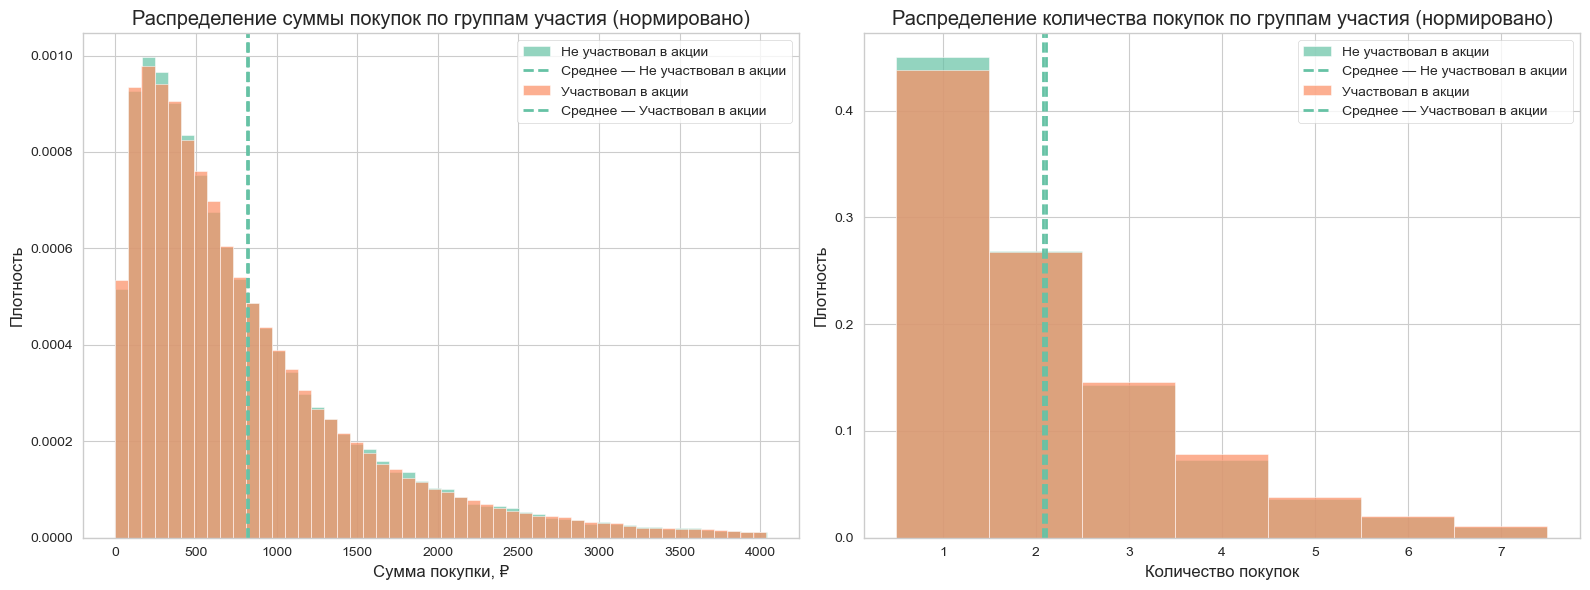

In [21]:
group_names = {0: 'Не участвовал в акции', 1: 'Участвовал в акции'}

# Фильтрация пользователей с ненулевой суммой покупок
df_nonzero = df_actions[df_actions["Sum_Purch_in_Action"] > 0]

plt.figure(figsize=(16, 6))

# Гистограмма суммы покупок по группам участия в акции (нормированная)
plt.subplot(1, 2, 1)
for i_action in [0, 1]:
    values = df_nonzero[df_nonzero["In_Action"] == i_action]["Sum_Purch_in_Action"]
    plt.hist(values, bins=50, alpha=0.7, density=True, label=group_names[i_action])
    plt.axvline(values.mean(), linestyle='dashed', linewidth=2, label=f'Среднее — {group_names[i_action]}')
plt.title('Распределение суммы покупок по группам участия (нормировано)')
plt.xlabel('Сумма покупки, ₽')
plt.ylabel('Плотность')
plt.legend()

# Гистограмма количества покупок по группам участия в акции (нормированная)
plt.subplot(1, 2, 2)
for i_action in [0, 1]:
    values = df_nonzero[df_nonzero["In_Action"] == i_action]["Qnt_Purch_in_Action"]
    plt.hist(
        values, bins=range(1, df_nonzero["Qnt_Purch_in_Action"].max() + 2),
        alpha=0.7, density=True, label=group_names[i_action], align='left'
    )
    plt.axvline(values.mean(), linestyle='dashed', linewidth=2, label=f'Среднее — {group_names[i_action]}')
plt.title('Распределение количества покупок по группам участия (нормировано)')
plt.xlabel('Количество покупок')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()

Видим, что визуально гистограммы практически совпадают. Проверим схожесть распределений каким-нибудь формальным критерием. Можем использовать тесты Колмогорова-Смирнова и Манна-Уитни. Будем считать уровнем значимости $5\%$

In [22]:
from scipy.stats import ks_2samp, mannwhitneyu

x0 = df_nonzero[df_nonzero["In_Action"] == 0]["Sum_Purch_in_Action"]
x1 = df_nonzero[df_nonzero["In_Action"] == 1]["Sum_Purch_in_Action"]
y0 = df_nonzero[df_nonzero["In_Action"] == 0]["Qnt_Purch_in_Action"]
y1 = df_nonzero[df_nonzero["In_Action"] == 1]["Qnt_Purch_in_Action"]

ks_stat_sum, p_sum = ks_2samp(x0, x1)
ks_stat_cnt, p_cnt = ks_2samp(y0, y1)
print(f"KS-тест для суммы покупок: p-value = {p_sum:.3f}")
print(f"KS-тест для количества покупок: p-value = {p_cnt:.3f}")

u_stat_sum, pu_sum = mannwhitneyu(x0, x1, alternative='two-sided')
u_stat_cnt, pu_cnt = mannwhitneyu(y0, y1, alternative='two-sided')
print(f"U-тест для суммы покупок: p-value = {pu_sum:.3f}")
print(f"U-тест для количества покупок: p-value = {pu_cnt:.3f}")

KS-тест для суммы покупок: p-value = 0.507
KS-тест для количества покупок: p-value = 0.000
U-тест для суммы покупок: p-value = 0.584
U-тест для количества покупок: p-value = 0.000


In [23]:
mean_no_action = df_nonzero[df_nonzero["In_Action"] == 0]["Qnt_Purch_in_Action"].mean()
mean_action = df_nonzero[df_nonzero["In_Action"] == 1]["Qnt_Purch_in_Action"].mean()

print(f'Средняя количество товаров (не участвовал в акции): {mean_no_action:.2f}')
print(f'Средняя количество (участвовал в акции): {mean_action:.2f}')

Средняя количество товаров (не участвовал в акции): 2.08
Средняя количество (участвовал в акции): 2.11


Видим, что с точки зрения обоих тестов различие всё же наблюдается для количества товаров, но не наблюдается для суммы. Однако заметим, что различие на самом деле очень слабое. Я склонен в данном случае считать, что акция не повлияла на среднюю сумму покупки и среднее количество товаров у тех, кто вообще что-то купил.

Проверим распределения с учётом тех, кто ничего не купил.

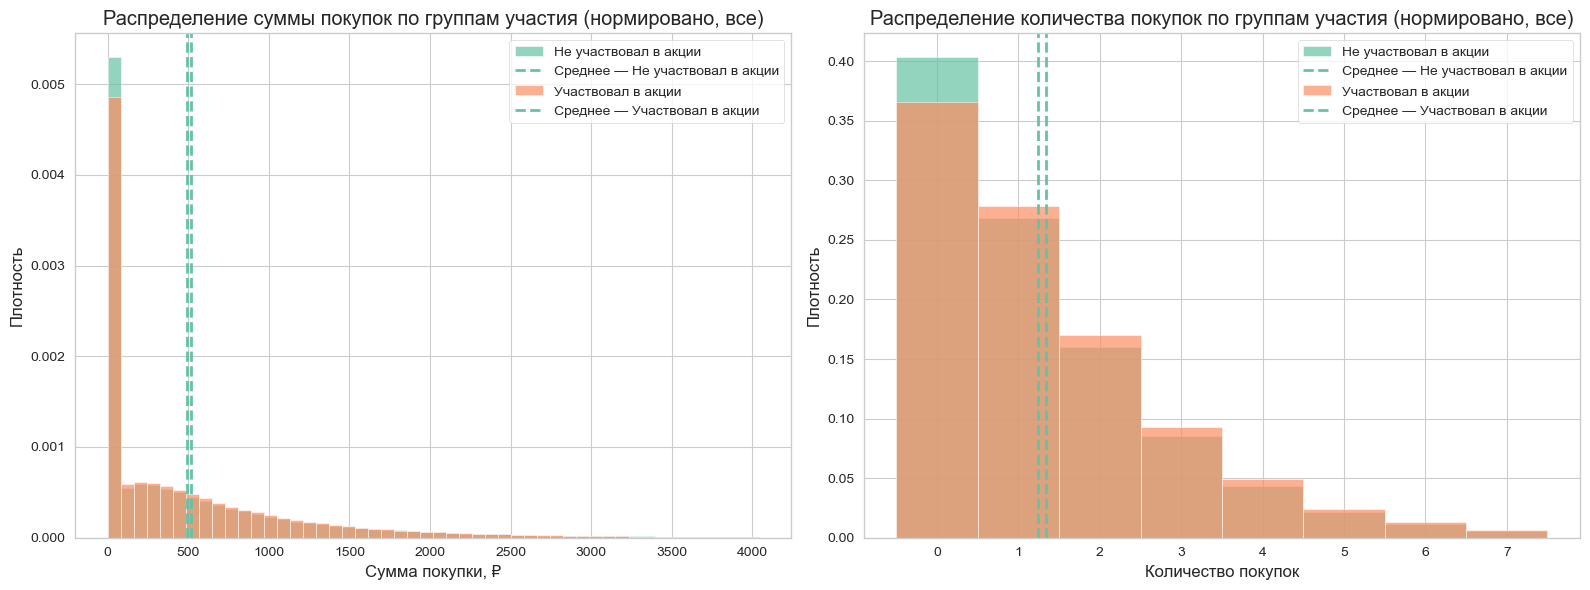

In [24]:
plt.figure(figsize=(16, 6))

# Гистограмма суммы покупок по группам участия в акции (нормированная)
plt.subplot(1, 2, 1)
for i_action in [0, 1]:
    values = df_actions[df_actions["In_Action"] == i_action]["Sum_Purch_in_Action"]
    plt.hist(values, bins=50, alpha=0.7, density=True, label=group_names[i_action])
    plt.axvline(values.mean(), linestyle='dashed', linewidth=2, label=f'Среднее — {group_names[i_action]}')
plt.title('Распределение суммы покупок по группам участия (нормировано, все)')
plt.xlabel('Сумма покупки, ₽')
plt.ylabel('Плотность')
plt.legend()

# Гистограмма количества покупок по группам участия в акции (нормированная)
plt.subplot(1, 2, 2)
for i_action in [0, 1]:
    values = df_actions[df_actions["In_Action"] == i_action]["Qnt_Purch_in_Action"]
    plt.hist(
        values, bins=range(0, df_actions["Qnt_Purch_in_Action"].max() + 2),
        alpha=0.7, density=True, label=group_names[i_action], align='left'
    )
    plt.axvline(values.mean(), linestyle='dashed', linewidth=2, label=f'Среднее — {group_names[i_action]}')
plt.title('Распределение количества покупок по группам участия (нормировано, все)')
plt.xlabel('Количество покупок')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
x0 = df_actions[df_actions["In_Action"] == 0]["Sum_Purch_in_Action"]
x1 = df_actions[df_actions["In_Action"] == 1]["Sum_Purch_in_Action"]
y0 = df_actions[df_actions["In_Action"] == 0]["Qnt_Purch_in_Action"]
y1 = df_actions[df_actions["In_Action"] == 1]["Qnt_Purch_in_Action"]

ks_stat_sum, p_sum = ks_2samp(x0, x1)
ks_stat_cnt, p_cnt = ks_2samp(y0, y1)
print(f"KS-тест для суммы покупок: p-value = {p_sum:.3f}")
print(f"KS-тест для количества покупок: p-value = {p_cnt:.3f}")

u_stat_sum, pu_sum = mannwhitneyu(x0, x1, alternative='two-sided')
u_stat_cnt, pu_cnt = mannwhitneyu(y0, y1, alternative='two-sided')
print(f"U-тест для суммы покупок: p-value = {pu_sum:.3f}")
print(f"U-тест для количества покупок: p-value = {pu_cnt:.3f}")

KS-тест для суммы покупок: p-value = 0.000
KS-тест для количества покупок: p-value = 0.000
U-тест для суммы покупок: p-value = 0.000
U-тест для количества покупок: p-value = 0.000


Оба теста показывают статистически значимое отличие для обоих параметров.

In [26]:
mean_sum_no_action = df_actions[df_actions["In_Action"] == 0]["Sum_Purch_in_Action"].mean()
mean_sum_action = df_actions[df_actions["In_Action"] == 1]["Sum_Purch_in_Action"].mean()
mean_qnt_no_action = df_actions[df_actions["In_Action"] == 0]["Qnt_Purch_in_Action"].mean()
mean_qnt_action = df_actions[df_actions["In_Action"] == 1]["Qnt_Purch_in_Action"].mean()

print(f'Средняя сумма покупки (не участвовал в акции): {mean_sum_no_action:.2f}')
print(f'Средняя сумма покупки (участвовал в акции): {mean_sum_action:.2f}')
print(f'Среднее количество товаров (не участвовал в акции): {mean_qnt_no_action:.2f}')
print(f'Среднее количество товаров (участвовал в акции): {mean_qnt_action:.2f}')

Средняя сумма покупки (не участвовал в акции): 490.71
Средняя сумма покупки (участвовал в акции): 519.87
Среднее количество товаров (не участвовал в акции): 1.24
Среднее количество товаров (участвовал в акции): 1.34


По итогу можем сформулировать следующую гипотезу: акция не привлекла новых клиентов и не повлияла на средний чек, но повлияла на желание уже имеющихся пользователей что-то у нас купить.

### Данные по товарам ('goods.csv')

In [27]:
get_df_info(df_goods)   

(43038, 11)


,Goods_BKEY,cat_lev_01_BKEY,cat_lev_02_BKEY,Cat_lev_03_BKEY,Cat_lev_04_BKEY,Attribut_01,Brand_BKEY,Manufator_BKEY,Waight,Self_Brand_flag,Alco_flag
0,5333,0,38,101,746,259.0,1683,2183,0.30,0,0
1,3875,0,38,101,746,259.0,1683,2183,0.70,0,0
2,3726,0,38,101,746,259.0,1683,2183,0.36,0,0
3,14038,0,38,101,746,259.0,1253,2183,0.60,0,0
4,12502,0,38,101,746,259.0,3284,1570,0.80,0,0


Есть пропуски:


Attribut_01    1572
Waight            3
dtype: int64

Здесь и далее я не исправляю опечатки в названиях столбцов, например "wAight", поскольку это может быть по различным причинам неудобно владельцу данных.

Смысл переменных cat_lev_0Х_BKEY неизвестны как и смысл Attribut_01. Нужно спрашивать у владельца данных, пока удаляем. Удаляем строчки с товарами, вес которых неизвестен.

In [28]:
# Удаляем строки с отсутствующим или нулевым весом
df_goods.dropna(subset=['Waight'], inplace=True)
df_goods = df_goods[df_goods['Waight'] > 0]

# Удаляем ненужные столбцы
cols_to_drop = ['cat_lev_01_BKEY', 'cat_lev_02_BKEY', 'Cat_lev_03_BKEY', 'Cat_lev_04_BKEY', 'Attribut_01']
df_goods.drop(columns=cols_to_drop, inplace=True)

In [29]:
df_goods.describe(include='all')

,Goods_BKEY,Brand_BKEY,Manufator_BKEY,Waight,Self_Brand_flag,Alco_flag
count,43031.000000,43031.000000,43031.000000,43031.000000,43031.000000,43031.000000
mean,21519.494109,2157.097255,1606.346541,0.537015,0.035184,0.055611
std,12424.344380,1435.893260,900.180614,8.274750,0.184247,0.229172
min,0.000000,1.000000,0.000000,0.001000,0.000000,0.000000
25%,10759.500000,951.000000,881.000000,0.150000,0.000000,0.000000
50%,21521.000000,2022.000000,1578.000000,0.300000,0.000000,0.000000
75%,32279.500000,3481.500000,2420.000000,0.500000,0.000000,0.000000
max,43037.000000,4296.000000,3193.000000,1150.000000,1.000000,1.000000


Видим, что по массе есть явный выброс, обрежем данные по 99-перцентилю.

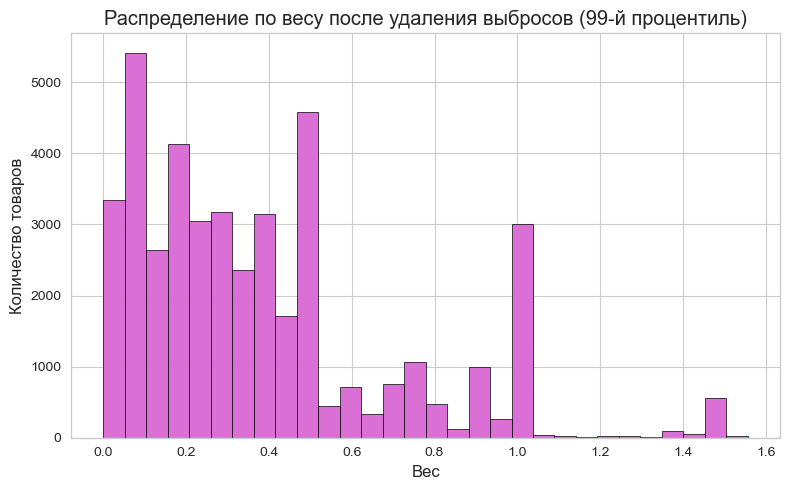

In [30]:
# Определяем 99-й процентиль
w_99 = df_goods['Waight'].quantile(0.99)

# Оставляем только те строки, где вес <= этого порога
df_goods = df_goods[df_goods['Waight'] <= w_99]

plt.figure(figsize=(8, 5))
plt.hist(df_goods['Waight'], bins=30, color='orchid', edgecolor='black')
plt.xlabel('Вес')
plt.ylabel('Количество товаров')
plt.title('Распределение по весу после удаления выбросов (99-й процентиль)')
plt.tight_layout()
plt.show()

In [31]:
print(df_goods.nunique())

Goods_BKEY         42600
Brand_BKEY          4272
Manufator_BKEY      3177
Waight               678
Self_Brand_flag        2
Alco_flag              2
dtype: int64


Видим, что производителей и брендов довольно много, так что, когда будем строить графики, ограничимся только наиболее представленными.

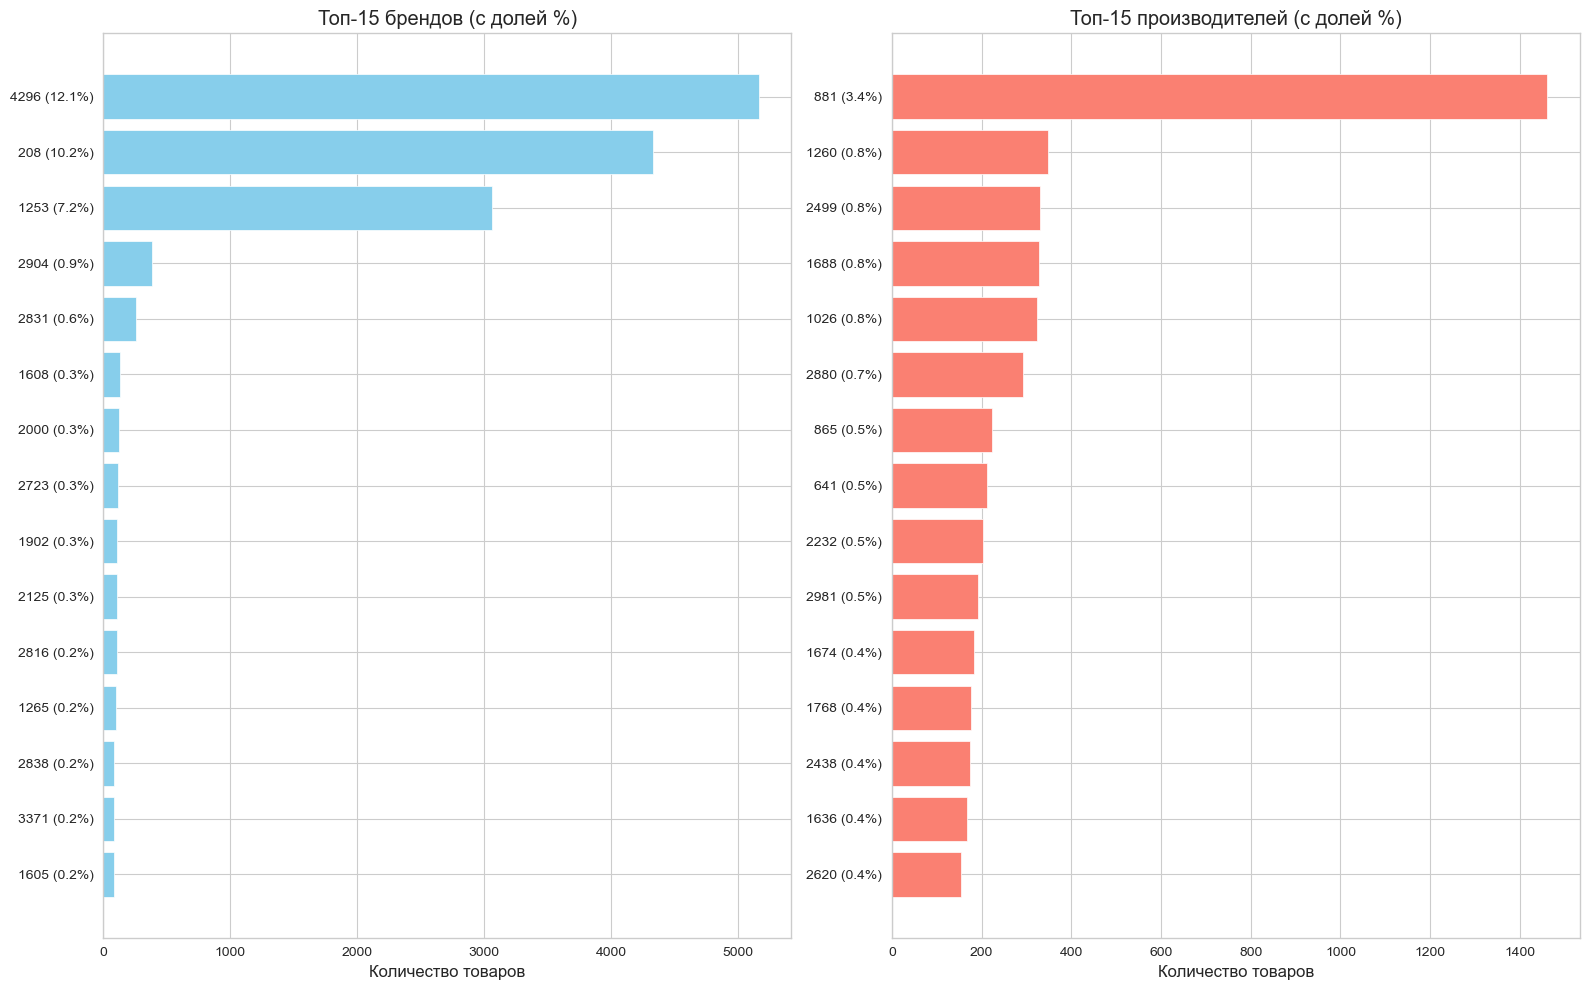

In [32]:
# Топ-15 брендов и проценты
top_brands = df_goods['Brand_BKEY'].value_counts().head(15)
total = df_goods['Brand_BKEY'].count()
brands_perc = (top_brands / total * 100).round(1)
brands_labels = [f"{idx} ({perc}%)" for idx, perc in zip(top_brands.index, brands_perc)]

# Топ-15 производителей и проценты
top_manuf = df_goods['Manufator_BKEY'].value_counts().head(15)
total_manuf = df_goods['Manufator_BKEY'].count()
manuf_perc = (top_manuf / total_manuf * 100).round(1)
manuf_labels = [f"{idx} ({perc}%)" for idx, perc in zip(top_manuf.index, manuf_perc)]

# Графики рядом
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Бренды
axes[0].barh(brands_labels[::-1], top_brands.values[::-1], color='skyblue')
axes[0].set_title('Топ-15 брендов (с долей %)')
axes[0].set_xlabel('Количество товаров')

# Производители
axes[1].barh(manuf_labels[::-1], top_manuf.values[::-1], color='salmon')
axes[1].set_title('Топ-15 производителей (с долей %)')
axes[1].set_xlabel('Количество товаров')

plt.tight_layout()
plt.show()

Видно, что есть три крайне популярных бренда (4296, 208 и 1253) из общего количества 4272, которые составляют почти $30\%$ продаж. По производителям картина иная, есть только один из 3177 относительно популярный, составляющий $3.4\%$ продаж, остальные заметно ниже.

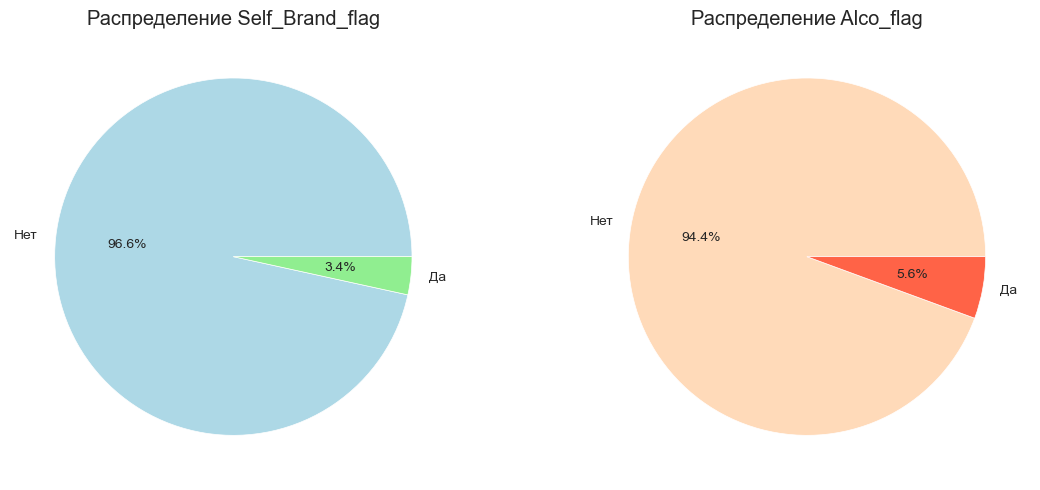

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Self_Brand_flag
df_goods['Self_Brand_flag'].value_counts().plot(
    kind='pie', ax=axes[0], autopct='%.1f%%', 
    labels=['Нет', 'Да'], colors=['lightblue', 'lightgreen'], 
    title='Распределение Self_Brand_flag'
)
axes[0].set_ylabel('')

# Alco_flag
df_goods['Alco_flag'].value_counts().plot(
    kind='pie', ax=axes[1], autopct='%.1f%%', 
    labels=['Нет', 'Да'], colors=['peachpuff', 'tomato'], 
    title='Распределение Alco_flag'
)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [34]:
# Всего товаров с алкоголем
n_alco = df_goods[df_goods['Alco_flag'] == 1].shape[0]

# Всего товаров со своим брендом
n_selfbrand = df_goods[df_goods['Self_Brand_flag'] == 1].shape[0]

# Одновременно и алкоголь, и свой бренд
n_both = df_goods[(df_goods['Alco_flag'] == 1) & (df_goods['Self_Brand_flag'] == 1)].shape[0]

# Процент от всего алкоголя
perc_of_alco = 100 * n_both / n_alco if n_alco > 0 else 0

# Процент от всего своего бренда
perc_of_selfbrand = 100 * n_both / n_selfbrand if n_selfbrand > 0 else 0

print(f'Позиций с алкоголем под своим брендом: {n_both}')
print(f'Это {perc_of_alco:.2f}% от всего алкоголя')
print(f'Это {perc_of_selfbrand:.2f}% от всего ассортимента собственного бренда')

Позиций с алкоголем под своим брендом: 422
Это 17.69% от всего алкоголя
Это 28.88% от всего ассортимента собственного бренда


Под своим брендом производится $3.5\%$ от проданных товаров, алкоголь составляет $5.6\%$ проданных товаров. Заметная часть алкоголя производится под своим брендом.

### Данные по операциям ('List_Purchases.parquet')

In [35]:
get_df_info(df_purchases) 

(57149006, 13)


,Person_BKEY,Purchase_ID,Opetation_datetime,toCard_stand,toCard_short,fromCard_stand,fromCard_short,Amount_Cheque,Merchant_id,Goods_BKEY,Qnt,Amount,Amount_Original
0,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30531,1.0,77.0,NaN
1,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,668,1.0,70.0,NaN
2,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,15558,1.0,28.0,NaN
3,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,24637,1.0,57.0,NaN
4,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,31933,2.0,162.0,NaN


Есть пропуски:


Amount_Original    53359663
dtype: int64

In [36]:
# оставляем только дату, убирая время
df_purchases['Opetation_datetime'] = pd.to_datetime(df_purchases['Opetation_datetime']).dt.date
# df_purchases.head()

In [37]:
#удаляем колонки 'toCard_short', 'fromCard_short', потому что их смысл мне непонятен, нужно спрашивать у владельца данных
# удаляем 'Amount_Original' состоящий почти целиком из пропусков
df_purchases = df_purchases.drop(['toCard_short', 'fromCard_short', 'Amount_Original'], axis=1)
# df_purchases.head()

In [38]:
df_purchases.head()

,Person_BKEY,Purchase_ID,Opetation_datetime,toCard_stand,fromCard_stand,Amount_Cheque,Merchant_id,Goods_BKEY,Qnt,Amount
0,162,5681805,2018-12-26,2.1,0.0,434.97,560,30531,1.0,77.0
1,162,2655010,2018-12-24,0.8,0.0,167.00,560,668,1.0,70.0
2,162,5681805,2018-12-26,2.1,0.0,434.97,560,15558,1.0,28.0
3,162,2655010,2018-12-24,0.8,0.0,167.00,560,24637,1.0,57.0
4,162,5681805,2018-12-26,2.1,0.0,434.97,560,31933,2.0,162.0


In [39]:
df_purchases.describe(include='all')

,Person_BKEY,Purchase_ID,Opetation_datetime,toCard_stand,fromCard_stand,Amount_Cheque,Merchant_id,Goods_BKEY,Qnt,Amount
count,5.714901e+07,5.714901e+07,57149006,5.714901e+07,5.714901e+07,5.714901e+07,5.714901e+07,5.714901e+07,5.714901e+07,5.714901e+07
unique,NaN,NaN,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,776243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.500353e+05,5.032607e+06,NaN,8.026715e+00,-5.295196e+00,7.756202e+02,6.931719e+03,2.084338e+04,1.247517e+00,7.345920e+01
std,1.442863e+05,2.905392e+06,NaN,1.257914e+01,3.596219e+01,7.926463e+02,4.008508e+03,1.272624e+04,2.854265e+00,8.753225e+01
min,0.000000e+00,0.000000e+00,NaN,0.000000e+00,-5.066000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.250030e+05,2.516872e+06,NaN,1.400000e+00,0.000000e+00,2.860000e+02,3.471000e+03,1.054200e+04,1.000000e+00,3.000000e+01
50%,2.500020e+05,5.033714e+06,NaN,3.700000e+00,0.000000e+00,5.388400e+02,6.921000e+03,1.951100e+04,1.000000e+00,5.100000e+01
75%,3.750210e+05,7.547852e+06,NaN,1.030000e+01,0.000000e+00,9.746500e+02,1.041700e+04,3.230500e+04,1.000000e+00,9.000000e+01


Удалим аномальные значения количества товаров и заодно превратим столбик в целочисленный.

In [40]:
# Находим 99-й процентиль
qnt_99 = df_purchases['Qnt'].quantile(0.99)

# Оставляем только значения до 99-го процентиля (включительно)
df_purchases = df_purchases[df_purchases['Qnt'] <= qnt_99]

# Также избавимся от отрицательных и нулевых значений, если это невалидно
df_purchases = df_purchases[df_purchases['Qnt'] > 0]

# Приводим к целому типу
df_purchases['Qnt'] = df_purchases['Qnt'].astype(int)
#df_purchases.describe(include='all')

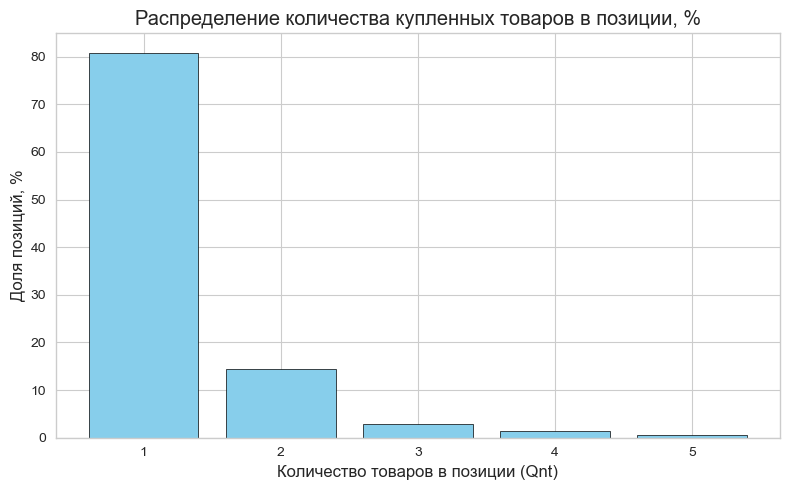

In [41]:
counts = df_purchases['Qnt'].value_counts().sort_index()
percents = 100 * counts / counts.sum()

plt.figure(figsize=(8,5))
plt.bar(percents.index, percents.values, color='skyblue', edgecolor='black', width=0.8)
plt.title('Распределение количества купленных товаров в позиции, %')
plt.xlabel('Количество товаров в позиции (Qnt)')
plt.ylabel('Доля позиций, %')
plt.xticks(percents.index)
plt.tight_layout()
plt.show()

Посмотрим распределение покупок по датам. Дополнительно отметим дату акции 2019-03-21

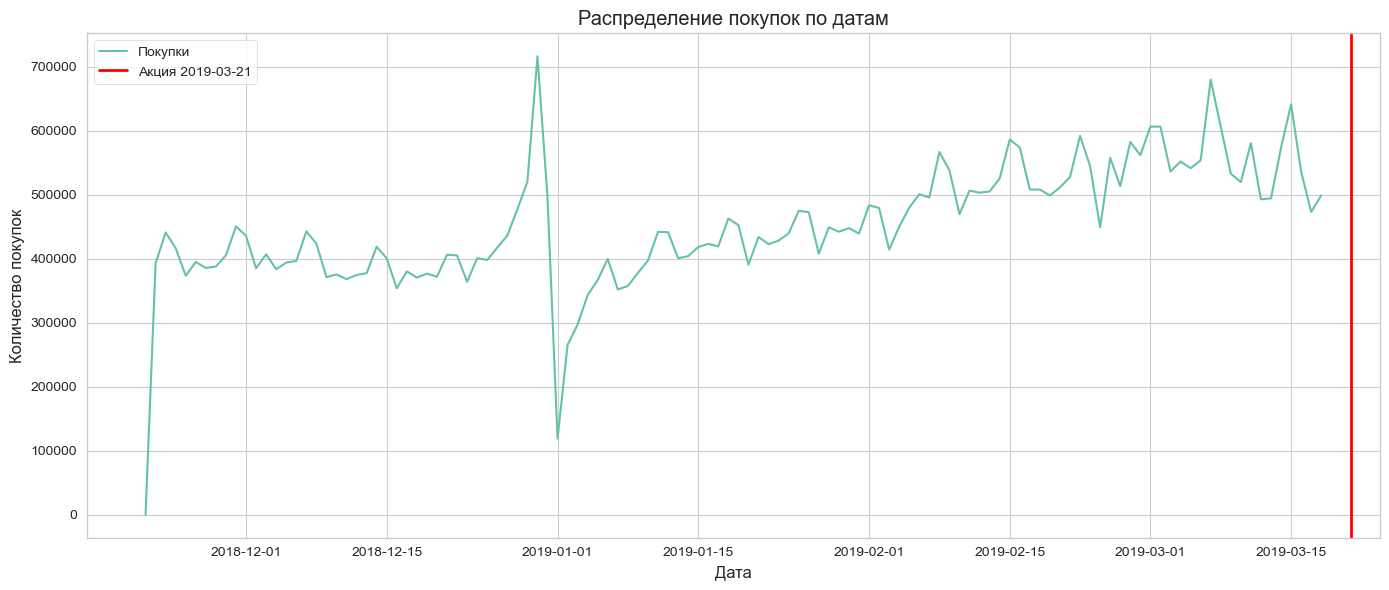

In [42]:
#преобразуем дату (на всякий случай)
df_purchases['Opetation_datetime'] = pd.to_datetime(df_purchases['Opetation_datetime'])

# Группируем по дате
date_counts = df_purchases['Opetation_datetime'].value_counts().sort_index()

plt.figure(figsize=(14,6))
plt.plot(date_counts.index, date_counts.values, label='Покупки')

# Яркая вертикальная линия для даты акции
plt.axvline(pd.Timestamp('2019-03-21'), color='red', linestyle='-', linewidth=2, label='Акция 2019-03-21')

plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.title('Распределение покупок по датам')
plt.legend()
plt.tight_layout()
plt.show()

- Все данные, которые у нас имеются по покупкам - это более ранние даты, чем дата акции. Изучить влияние акции на продажи не получится.
- Видим резкий рост покупок перед новым годом и резкое падение после. Достаточно обычная картина, если мы продаём, например, продукты питания - люди закупаются к новогоднему столу.
- Наблюдается тренд на рост продаж в 2019 году. Мы знаем, что число новых клиентов упало по сравнению с 2018 годом из графика, приведённого выше. Возможно, удалось завлечь обратно ушедших ранее клиентов? Нужно отдельно разбираться.

Посмотрим теперь на распределение товаров по числу заказов и полученной сумме. Если значение 'Amount' действительно показывает стоимость товара, конечно. Здесь стоило бы уточнить у владельца данных.

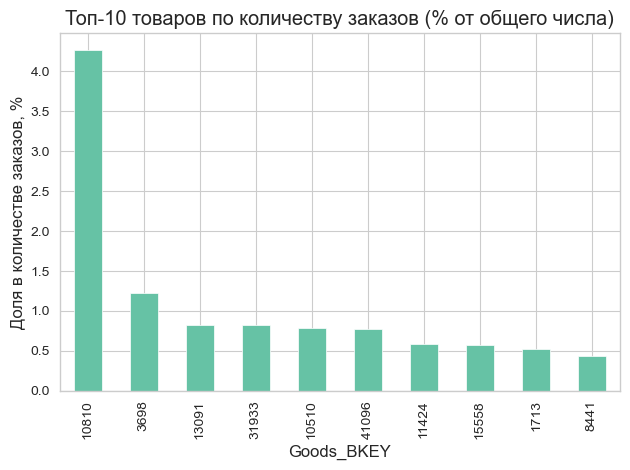

In [43]:
# Группируем по товарам и считаем количество заказов (строк)
goods_orders = df_purchases.groupby('Goods_BKEY')['Purchase_ID'].count()
top10_goods_orders = goods_orders.sort_values(ascending=False).head(10)

# Считаем проценты от общего числа заказов
total_orders = goods_orders.sum()
top10_orders_percent = 100 * top10_goods_orders / total_orders

# Строим барчарт
top10_orders_percent.plot(kind='bar')
plt.title('Топ-10 товаров по количеству заказов (% от общего числа)')
plt.ylabel('Доля в количестве заказов, %')
plt.xlabel('Goods_BKEY')
plt.tight_layout()
plt.show()

In [44]:
good_id = 10810

# Общая выручка по всем товарам
total_revenue = df_purchases['Amount'].sum()

# Выручка по нужному товару
revenue_goods = df_purchases[df_purchases['Goods_BKEY'] == good_id]['Amount'].sum()

# Процент выручки
percent_revenue = 100 * revenue_goods / total_revenue

# Общее количество заказов
total_orders = len(df_purchases)

# Количество заказов по товару
orders_goods = (df_purchases['Goods_BKEY'] == good_id).sum()

# Процент заказов
percent_orders = 100 * orders_goods / total_orders

print(f"Товар {good_id}:")
print(f"  Выручка: {revenue_goods:.2f} ({percent_revenue:.2f}% от всей выручки)")
print(f"  Количество заказов: {orders_goods} ({percent_orders:.2f}% от всех заказов)")

Товар 10810:
  Выручка: 12473612.00 (0.32% от всей выручки)
  Количество заказов: 2274455 (4.26% от всех заказов)


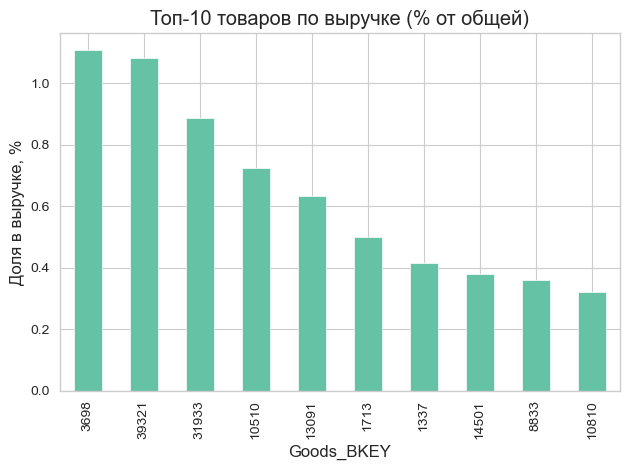

In [45]:
# Группируем по товарам, считаем выручку и сортируем
goods_revenue = df_purchases.groupby('Goods_BKEY')['Amount'].sum()
top10_goods = goods_revenue.sort_values(ascending=False).head(10)

# Считаем проценты от общей выручки
total_revenue = goods_revenue.sum()
top10_percent = 100 * top10_goods / total_revenue

# Барчарт
top10_percent.plot(kind='bar')
plt.title('Топ-10 товаров по выручке (% от общей)')
plt.ylabel('Доля в выручке, %')
plt.xlabel('Goods_BKEY')
plt.tight_layout()
plt.show()

Видим, что у нас очень часто берут товар 10810 - почти $4\%$ от всех покупок, но при этом в силу своей дешевизны он не входит даже в топ-10 товаров по полученной за него выручке, которая составляет всего $0.3\%$ от общей суммы. Вместо него высокую выручку приносят другие товары, например 39321

Посмотрим на распределение товаров по стоимости.

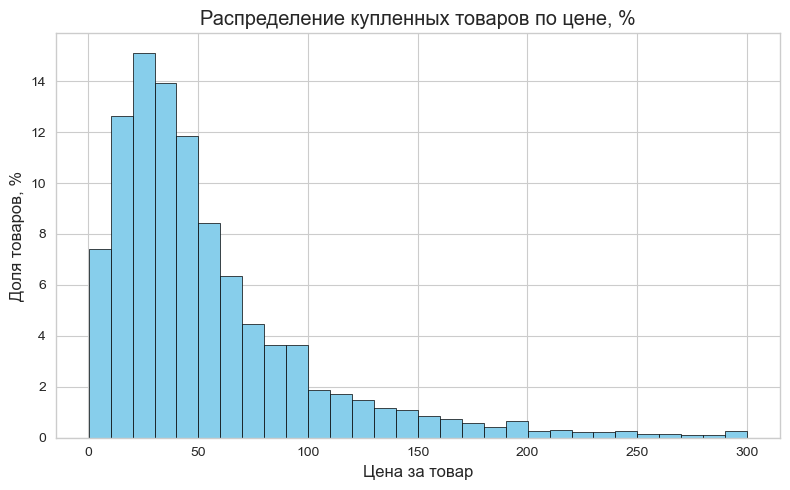

In [46]:
# Цена одной единицы товара (для каждой строки)
df_purchases['Item_Price'] = df_purchases['Amount'] / df_purchases['Qnt']

# Отбросим строки с невалидными или нулевыми (или отрицательными) ценами и количествами
df_items = df_purchases[(df_purchases['Qnt'] > 0) & (df_purchases['Item_Price'] > 0)].copy()

# Ограничим распределение по 99-му процентилю цены, чтобы убрать аномалии
price_99 = df_items['Item_Price'].quantile(0.99)
df_items = df_items[df_items['Item_Price'] <= price_99]

prices = np.repeat(df_items['Item_Price'].values, df_items['Qnt'].values.astype(int))

# Гистограмма распределения В КОЛ-ВЕ товаров по их цене:
bins = 30  #можно изменить число корзин по вкусу
counts, bin_edges = np.histogram(prices, bins=bins)
percents = 100 * counts / counts.sum()

plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], percents, width=np.diff(bin_edges), color='skyblue', edgecolor='black', align='edge')
plt.title('Распределение купленных товаров по цене, %')
plt.xlabel('Цена за товар')
plt.ylabel('Доля товаров, %')
plt.tight_layout()
plt.show()

df_purchases.drop(columns=['Item_Price'], inplace=True)

Видим, что в целом у нас покупают скорее недорогие товары.

Посмотрим на среднюю сумму чека

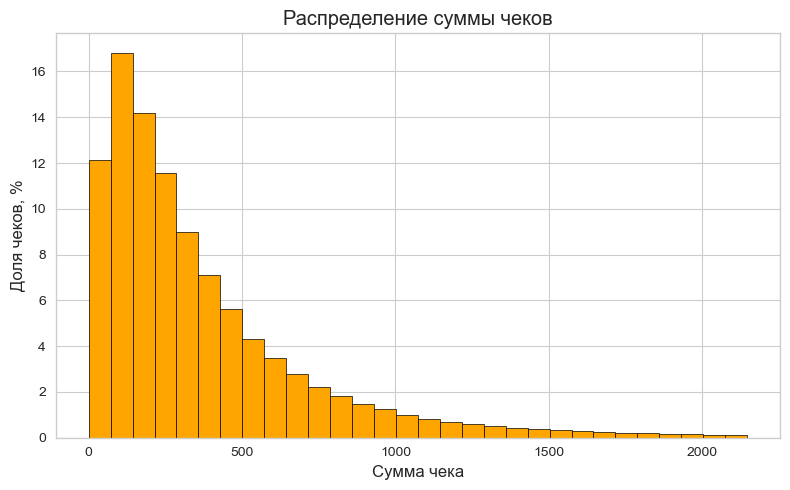

In [47]:
# 1. Удалим неадекватные значения и приведём к int
# Чистим по количеству (оставим только 1 <= Qnt <= 100, например, по данным)
df_clean = df_purchases[(df_purchases['Qnt'] > 0) & (df_purchases['Qnt'] < 100)].copy()
df_clean['Qnt'] = df_clean['Qnt'].astype(int)

# 2. Посчитаем сумму чека для каждого Purchase_ID
check_amounts = df_clean.groupby('Purchase_ID')['Amount'].sum().reset_index()
check_amounts.rename(columns={'Amount': 'Check_Amount'}, inplace=True)

# 3. Ограничим аномалии (например, по 99-му процентилю)
q99 = check_amounts['Check_Amount'].quantile(0.99)
check_amounts = check_amounts[check_amounts['Check_Amount'] <= q99]

# 4. Гистограмма
bins = 30
counts, bin_edges = np.histogram(check_amounts['Check_Amount'], bins=bins)
percents = 100 * counts / counts.sum()

plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], percents, width=np.diff(bin_edges), color='orange', edgecolor='black', align='edge')
plt.title('Распределение суммы чеков')
plt.xlabel('Сумма чека')
plt.ylabel('Доля чеков, %')
plt.tight_layout()
plt.show()

Сумма чека тоже относительно невысокая. Скорее всего мы продаём что-то вроде продуктов питания: недорого, но относительно много.

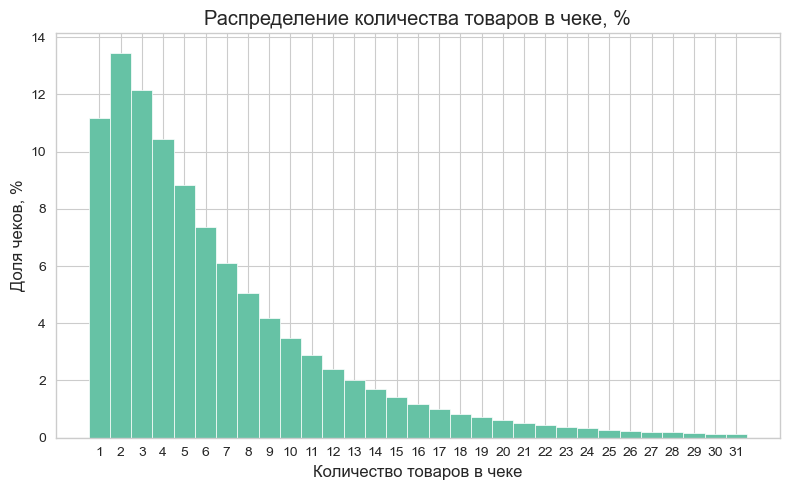

In [48]:
# Получаем распределение: суммарное число товаров в каждом чеке
goods_per_check = df_purchases.groupby('Purchase_ID')['Qnt'].sum()

# Можно отсечь выбросы по 99-му процентилю (по желанию)
goods_per_check = goods_per_check[goods_per_check < goods_per_check.quantile(0.99)]

# 3. Строим гистограмму в процентах
bins = np.arange(1, goods_per_check.max() + 2) - 0.5  # поштучно/целочисленно
counts, bin_edges = np.histogram(goods_per_check, bins=bins)
percents = 100 * counts / counts.sum()

plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1] + 0.5, percents, width=1, align='center')
plt.title('Распределение количества товаров в чеке, %')
plt.xlabel('Количество товаров в чеке')
plt.ylabel('Доля чеков, %')
plt.xticks(range(1, int(goods_per_check.max()) + 1))
plt.tight_layout()
plt.show()

Посмотрим на распределение покупок по магазинам: по количеству и по сумме.

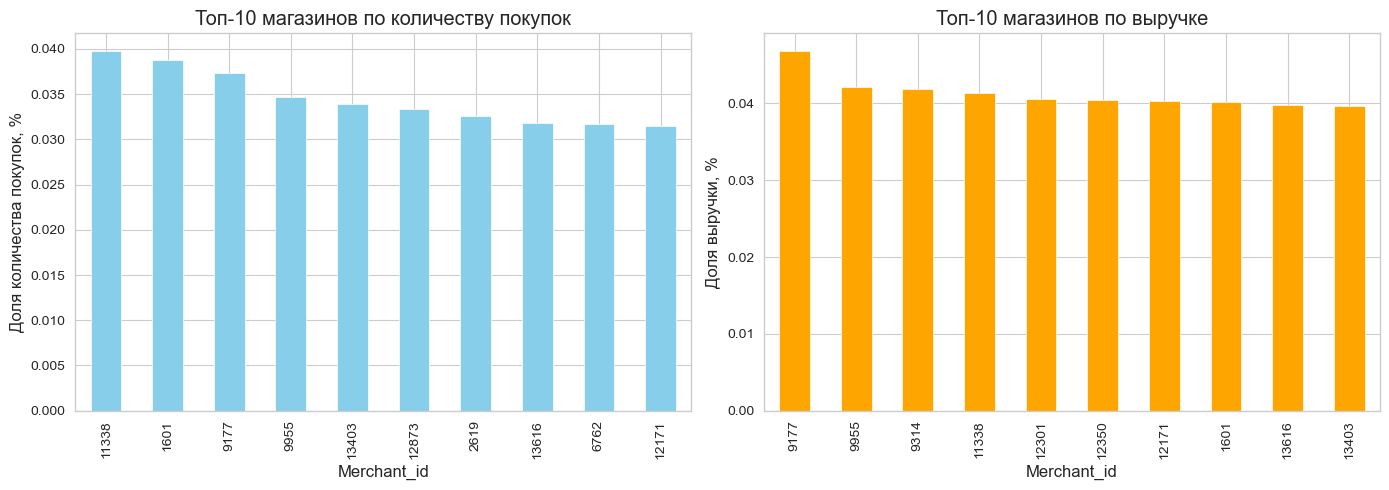

In [49]:
# Топ-10 по количеству покупок
orders_10 = (df_purchases.groupby('Merchant_id')['Purchase_ID']
             .count().sort_values(ascending=False).head(10))
orders_10_percent = 100 * orders_10 / df_purchases['Purchase_ID'].count()

# Топ-10 по сумме продаж
revenue_10 = (df_purchases.groupby('Merchant_id')['Amount']
              .sum().sort_values(ascending=False).head(10))
revenue_10_percent = 100 * revenue_10 / df_purchases['Amount'].sum()

fig, axs = plt.subplots(1, 2, figsize=(14,5))

orders_10_percent.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Топ-10 магазинов по количеству покупок')
axs[0].set_xlabel('Merchant_id')
axs[0].set_ylabel('Доля количества покупок, %')

revenue_10_percent.plot(kind='bar', ax=axs[1], color='orange')
axs[1].set_title('Топ-10 магазинов по выручке')
axs[1].set_xlabel('Merchant_id')
axs[1].set_ylabel('Доля выручки, %')

plt.tight_layout()
plt.show()

Без аномалий. Неплохо показывают себя, например, магазины 9177 и 11338, входя в оба топа на высоких позициях.

Построим распределение покупок по дня недели.

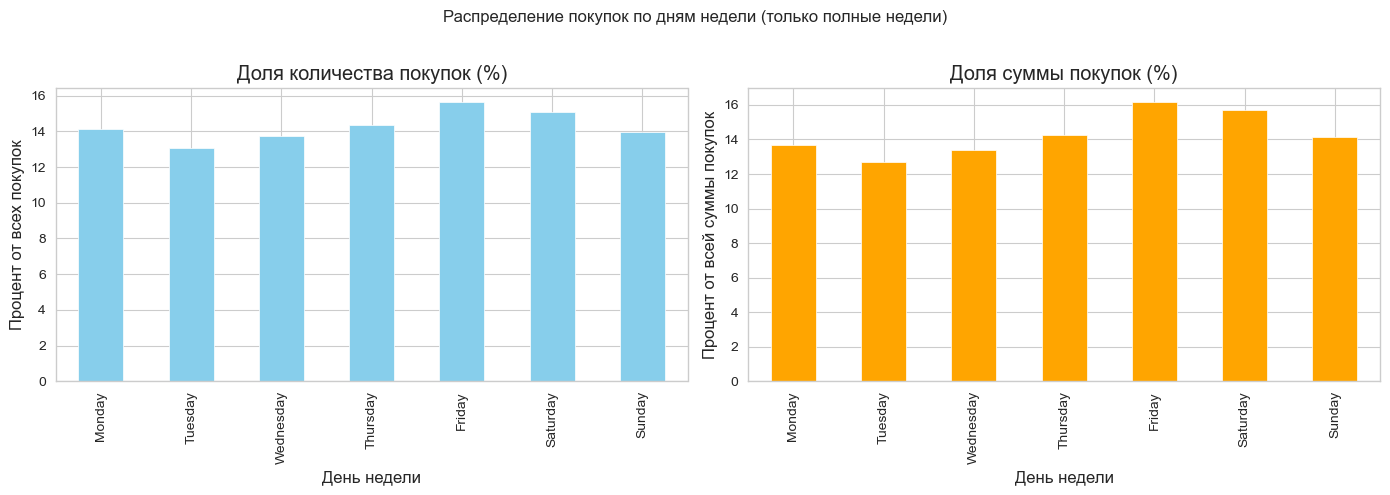

In [50]:
# Находим минимальную и максимальную даты
min_date = df_purchases['Opetation_datetime'].min()
max_date = df_purchases['Opetation_datetime'].max()

# Ближайший следующий понедельник и последний предыдущий воскресенье
start_monday = min_date + pd.DateOffset(days=(7 - min_date.weekday()) % 7)
end_sunday = max_date - pd.DateOffset(days=(max_date.weekday() - 6) % 7)

# Обрезаем для полных недель
df_full_weeks = df_purchases[
    (df_purchases['Opetation_datetime'] >= start_monday) &
    (df_purchases['Opetation_datetime'] <= end_sunday)
].copy()

# Делаем столбец с днем недели
df_full_weeks['day_of_week'] = df_full_weeks['Opetation_datetime'].dt.day_name()

# Считаем количество покупок и сумму по дням недели
orders_by_day = df_full_weeks.groupby('day_of_week')['Purchase_ID'].count().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
orders_by_day_percent = 100 * orders_by_day / orders_by_day.sum()

amount_by_day = df_full_weeks.groupby('day_of_week')['Amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
amount_by_day_percent = 100 * amount_by_day / amount_by_day.sum()

# Строим два графика рядом
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

orders_by_day_percent.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Доля количества покупок (%)')
axs[0].set_xlabel('День недели')
axs[0].set_ylabel('Процент от всех покупок')

amount_by_day_percent.plot(kind='bar', ax=axs[1], color='orange')
axs[1].set_title('Доля суммы покупок (%)')
axs[1].set_xlabel('День недели')
axs[1].set_ylabel('Процент от всей суммы покупок')

plt.suptitle('Распределение покупок по дням недели (только полные недели)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Видим, что у нас активнее закупаются перед выходными и меньше в середине рабочей недели. Это важная информация, которую может быть необходимо учитывать при планировании акций. Аналогичное распределение можно построить по часам в течение дня.

### Данные по чекам ('List_Cheques.parquet')

In [51]:
get_df_info(df_cheques) 

(10065266, 11)


,Person_BKEY,Purchase_ID,Amount_Original,Amount,toCard_stand,toCard_short,fromCard_stand,fromCard_short,Amount_Cheque,Merchant_id,Opetation_datetime
0,0,4169120,0.0,804.0,8.0,0.0,0.0,0.0,803.0,81,2019-03-08 10:12:03
1,0,4962998,0.0,1007.0,10.0,0.0,0.0,0.0,1007.0,4557,2018-12-01 07:12:45
2,0,7048393,0.0,419.0,2.0,0.0,0.0,0.0,419.0,81,2019-03-14 15:01:47
3,0,7618050,0.0,575.0,5.7,0.0,0.0,0.0,574.0,12891,2018-12-16 08:56:01
4,1,402585,0.0,700.0,7.0,0.0,0.0,0.0,700.0,3166,2018-12-21 11:08:58


Нет пропусков


In [52]:
# Удаляем ненужные столбцы
df_cheques = df_cheques.drop(columns=['toCard_short', 'fromCard_short', 'Amount_Original'])

# Оставляем только дату в Opetation_datetime
df_cheques['Opetation_datetime'] = pd.to_datetime(df_cheques['Opetation_datetime']).dt.date

In [53]:
df_cheques.describe(include='all')

,Person_BKEY,Purchase_ID,Amount,toCard_stand,fromCard_stand,Amount_Cheque,Merchant_id,Opetation_datetime
count,1.006527e+07,1.006527e+07,1.006527e+07,1.006527e+07,1.006527e+07,1.006527e+07,1.006527e+07,10065266
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-07
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128894
mean,2.502055e+05,5.032632e+06,4.178166e+02,3.877290e+00,-3.642074e+00,4.276588e+02,6.934241e+03,NaN
std,1.442181e+05,2.905592e+06,4.794765e+02,7.763576e+00,2.553037e+01,4.877144e+02,4.000161e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.066000e+03,0.000000e+00,0.000000e+00,NaN
25%,1.252580e+05,2.516316e+06,1.350000e+02,6.000000e-01,0.000000e+00,1.400000e+02,3.487000e+03,NaN
50%,2.504450e+05,5.032632e+06,2.750000e+02,1.400000e+00,0.000000e+00,2.820000e+02,6.926000e+03,NaN
75%,3.750880e+05,7.548949e+06,5.220000e+02,3.900000e+00,0.000000e+00,5.330000e+02,1.041000e+04,NaN


Видно явный выброс в Amount, можно строить графички, но пока оставим эту табличку в силу ограниченного времени.

## Объединяем таблицы

In [54]:
df_sales= pd.merge(df_purchases, df_goods, on='Goods_BKEY', how='left')
df_sales.head()

,Person_BKEY,Purchase_ID,Opetation_datetime,toCard_stand,fromCard_stand,Amount_Cheque,Merchant_id,Goods_BKEY,Qnt,Amount,Brand_BKEY,Manufator_BKEY,Waight,Self_Brand_flag,Alco_flag
0,162,5681805,2018-12-26,2.1,0.0,434.97,560,30531,1,77.0,1931.0,188.0,0.221,0.0,0.0
1,162,2655010,2018-12-24,0.8,0.0,167.00,560,668,1,70.0,2331.0,1360.0,1.049,0.0,0.0
2,162,5681805,2018-12-26,2.1,0.0,434.97,560,15558,1,28.0,1253.0,2880.0,1.000,0.0,0.0
3,162,2655010,2018-12-24,0.8,0.0,167.00,560,24637,1,57.0,2687.0,2956.0,1.000,0.0,0.0
4,162,5681805,2018-12-26,2.1,0.0,434.97,560,31933,2,162.0,1253.0,2880.0,1.000,0.0,0.0


In [55]:
df_full = pd.merge(df_sales, df_persons, on='Person_BKEY', how='left')
df_full.head()

,Person_BKEY,Purchase_ID,Opetation_datetime,toCard_stand,fromCard_stand,Amount_Cheque,Merchant_id,Goods_BKEY,Qnt,Amount,Brand_BKEY,Manufator_BKEY,Waight,Self_Brand_flag,Alco_flag,First_Purch_date,Age,Gend
0,162,5681805,2018-12-26,2.1,0.0,434.97,560,30531,1,77.0,1931.0,188.0,0.221,0.0,0.0,2018-07-06,52.0,F
1,162,2655010,2018-12-24,0.8,0.0,167.00,560,668,1,70.0,2331.0,1360.0,1.049,0.0,0.0,2018-07-06,52.0,F
2,162,5681805,2018-12-26,2.1,0.0,434.97,560,15558,1,28.0,1253.0,2880.0,1.000,0.0,0.0,2018-07-06,52.0,F
3,162,2655010,2018-12-24,0.8,0.0,167.00,560,24637,1,57.0,2687.0,2956.0,1.000,0.0,0.0,2018-07-06,52.0,F
4,162,5681805,2018-12-26,2.1,0.0,434.97,560,31933,2,162.0,1253.0,2880.0,1.000,0.0,0.0,2018-07-06,52.0,F


C:\Users\Юрий\AppData\Local\Temp\ipykernel_25104\662709777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cheques['Age_group'] = pd.cut(cheques['Age'], bins=bins, labels=labels, right=False)
C:\Users\Юрий\AppData\Local\Temp\ipykernel_25104\662709777.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_cheque = cheques.groupby(['Age_group', 'Gend'])['Amount_Cheque'].mean().reset_index()


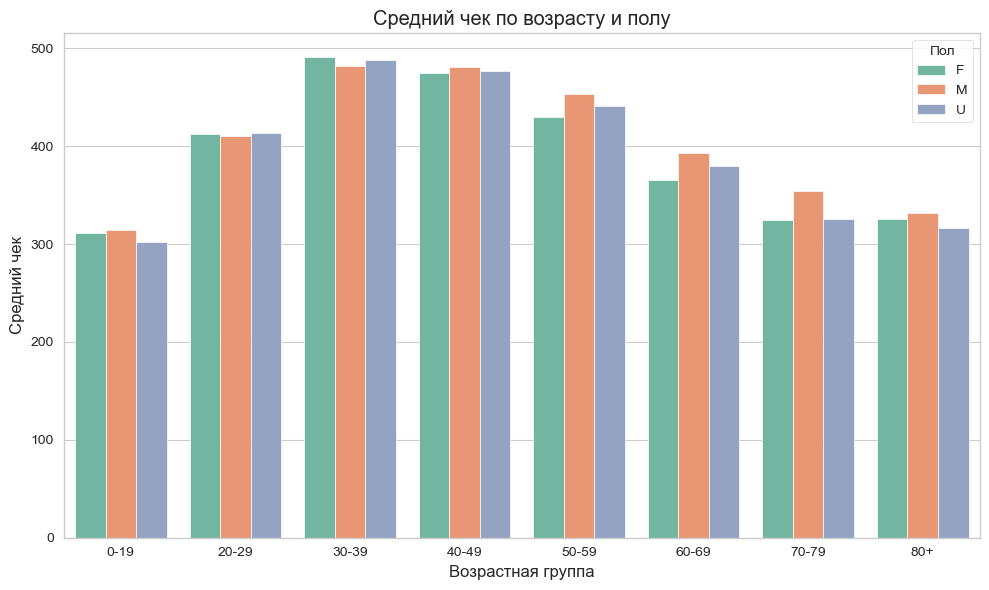

In [56]:
# Оставляем только уникальные чеки
cheques = df_full.drop_duplicates(subset=['Purchase_ID'])

# Создаем возрастные группы (десятилетия)
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
cheques['Age_group'] = pd.cut(cheques['Age'], bins=bins, labels=labels, right=False)

# Группируем и считаем средний чек по возрасту и полу
mean_cheque = cheques.groupby(['Age_group', 'Gend'])['Amount_Cheque'].mean().reset_index()

# Визуализируем
plt.figure(figsize=(10,6))
sns.barplot(data=mean_cheque, x='Age_group', y='Amount_Cheque', hue='Gend')
plt.ylabel('Средний чек')
plt.xlabel('Возрастная группа')
plt.title('Средний чек по возрасту и полу')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()